In [20]:
%%writefile data_loader.py
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import os
from datetime import datetime
import matplotlib.pyplot as plt
from visualization import plot_and_save_scatter

class DataLoader:
    """
    Lớp tải dữ liệu từ các nguồn khác nhau.
    """
    def __init__(self):
        self.X = None
        self.true_labels = None
        self.n_cluster = None
        self.is_iris = False
        self.xlabel = 'x'
        self.ylabel = 'y'

    def load_data(self):
        """
        Tải dữ liệu dựa trên lựa chọn của người dùng và xử lý lưu trữ.
        """
        print("Các chế độ tạo dữ liệu:")
        print("1. Tạo ngẫu nhiên (nhập số điểm và cụm)")
        print("2. Load từ file CSV (chứa cột 'x' và 'y')")
        print("3. Load dataset thực tế: Iris (sử dụng 2 đặc trưng đầu để visualize 2D)")
        choice = input("Nhập lựa chọn (1, 2, hoặc 3): ").strip()

        # Tạo thư mục results
        os.makedirs('results', exist_ok=True)
        print("Thư mục 'results/' đã sẵn sàng.")

        if choice == '1':
            self._load_random()
        elif choice == '2':
            self._load_csv()
        elif choice == '3':
            self._load_iris()
        else:
            print("Lựa chọn không hợp lệ. Sử dụng Iris dataset mặc định.")
            self._load_iris()

        # Visualize và lưu dữ liệu ban đầu
        self._plot_and_save_initial_data()

    def _load_random(self):
        n_samples_total = int(input("Nhập tổng số lượng điểm dữ liệu (ví dụ: 500): "))
        self.n_cluster = int(input("Nhập số lượng cụm (K) (ví dụ: 3): "))

        # Tạo tâm cụm mẫu
        if self.n_cluster == 3:
            means = [[2, 2], [9, 2], [4, 9]]
        else:
            np.random.seed(42)
            means = np.random.uniform(0, 10, (self.n_cluster, 2)).tolist()
            print(f"Tạo {self.n_cluster} tâm cụm ngẫu nhiên: {means}")

        cov = [[2, 0], [0, 2]]

        # Tạo dữ liệu
        n_samples_per_cluster = n_samples_total // self.n_cluster
        remainder = n_samples_total % self.n_cluster
        X_list = []
        for i in range(self.n_cluster):
            current_samples = n_samples_per_cluster + (1 if i < remainder else 0)
            Xi = np.random.multivariate_normal(means[i], cov, current_samples)
            X_list.append(Xi)
        self.X = np.concatenate(X_list, axis=0)
        print(f"Tạo dữ liệu ngẫu nhiên: {self.X.shape[0]} điểm trong {self.n_cluster} cụm.")

        # Lưu file CSV
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        df = pd.DataFrame(self.X, columns=['x', 'y'])
        df.to_csv(f'results/generated_data_{timestamp}.csv', index=False)
        print(f"Lưu dữ liệu vào results/generated_data_{timestamp}.csv")

    def _load_csv(self):
        file_path = input("Nhập đường dẫn file CSV (ví dụ: data.csv): ").strip()
        try:
            df = pd.read_csv(file_path)
            self.X = df[['x', 'y']].values
            print(f"Load dữ liệu từ file: {self.X.shape[0]} điểm.")
        except Exception as e:
            print(f"Lỗi khi load file: {e}. Sử dụng dữ liệu mẫu mặc định.")
            self.X = np.random.rand(100, 2) * 10
            print("Sử dụng dữ liệu mẫu: 100 điểm ngẫu nhiên.")

        self.n_cluster = int(input("Nhập số lượng cụm (K) (ví dụ: 3): "))

    def _load_iris(self):
        iris = load_iris()
        self.X = iris.data[:, :2]
        self.true_labels = iris.target
        self.is_iris = True
        self.xlabel = 'Đặc trưng 1 (sepal length)'
        self.ylabel = 'Đặc trưng 2 (sepal width)'
        print(f"Load Iris dataset: {self.X.shape[0]} điểm, 2 đặc trưng (sepal length, sepal width).")
        print("Nhãn thực tế: 0=setosa, 1=versicolor, 2=virginica.")
        print("Gợi ý: K=3 cho 3 loài hoa.")
        self.n_cluster = int(input("Nhập số lượng cụm (K) (ví dụ: 3): "))

    def _plot_and_save_initial_data(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        title = 'Dữ liệu ban đầu (màu theo nhãn thực tế)' if self.is_iris and self.true_labels is not None else 'Dữ liệu ban đầu'
        marker = 'o'
        s = 10

        if self.is_iris and self.true_labels is not None:
            c = self.true_labels
            cmap = 'viridis'
        else:
            c = 'blue'
            cmap = None

        plot_and_save_scatter(self.X, c, title, self.xlabel, self.ylabel, marker, s, cmap, f'initial_data_{timestamp}')

Writing data_loader.py


In [21]:
%%writefile kmeans_model.py
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
from visualization import plot_and_save_scatter, plot_and_save_comparison

class KMeansModel:
    """
    Lớp triển khai thuật toán K-Means (không visualize từng bước, chỉ fit với verbose).
    """
    def __init__(self, n_clusters, max_iter=100, tolerance=1e-4, seed=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.seed = seed
        np.random.seed(seed)
        self.centers = None
        self.labels = None
        self.iterations = 0
        self.X = None

    def _init_centers(self, X):
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _predict_labels(self, X, centers):
        D = cdist(X, centers)
        return np.argmin(D, axis=1)

    def _update_centers(self, X, labels):
        centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            Xk = X[labels == k, :]
            if len(Xk) > 0:
                centers[k] = np.mean(Xk, axis=0)
            else:
                centers[k] = X[np.random.choice(X.shape[0])]
        return centers

    def _has_converged(self, centers, new_centers):
        return np.all(np.abs(centers - new_centers) < self.tolerance)

    def fit(self, X, verbose=True):
        self.X = X
        init_centers = self._init_centers(X)
        labels = np.zeros(X.shape[0], dtype=int)
        centers = init_centers.copy()

        if verbose:
            print("=== BƯỚC 1: KHỞI TẠO TÂM CỤM NGẪU NHIÊN ===")
            for i, center in enumerate(centers):
                print(f"  Tâm {i}: {center}")

        self.iterations = 0
        while self.iterations < self.max_iter:
            self.iterations += 1
            if verbose:
                print(f"\n--- Lần lặp {self.iterations} ---")

            old_labels = labels.copy()
            labels = self._predict_labels(X, centers)
            num_changes = np.sum(labels != old_labels)
            if verbose:
                print(f"  Gán nhãn: {np.bincount(labels, minlength=self.n_clusters)} điểm mỗi cụm")
                print(f"  Số điểm thay đổi nhãn: {num_changes}")

            new_centers = self._update_centers(X, labels)
            if verbose:
                print("  Tâm cụm mới:")
                for i, center in enumerate(new_centers):
                    print(f"    Tâm {i}: {center}")

            if self._has_converged(centers, new_centers):
                if verbose:
                    print(f"  → Hội tụ! Không thay đổi đáng kể (ngưỡng {self.tolerance}).")
                centers = new_centers
                break
            centers = new_centers

        if self.iterations >= self.max_iter and verbose:
            print(f"  → Đạt tối đa {self.max_iter} lần lặp mà chưa hội tụ.")

        self.centers = centers
        self.labels = labels

        if verbose:
            print(f"\n=== BƯỚC 3: KẾT QUẢ CUỐI CÙNG ===")
            print(f"Thuật toán hội tụ sau {self.iterations} lần lặp.")
            print("Phân bố nhãn cuối:")
            print(np.bincount(labels, minlength=self.n_clusters))
            print("Tâm cụm cuối:")
            for i, center in enumerate(centers):
                print(f"  Tâm {i}: {center}")

        return self

    def plot_and_save_results(self, true_labels=None, xlabel='x', ylabel='y'):
        """
        Vẽ và lưu ảnh kết quả cuối cùng.
        """
        # Chuẩn bị dữ liệu cho scatter: Tách cụm và tâm
        scatters = []
        for i in range(self.n_clusters):
            data = self.X[self.labels == i]
            scatters.append((data[:, 0], data[:, 1], {'color': 'b', 'marker': 'o', 's': 30, 'alpha': 0.7, 'label': f'Cụm {i} ({len(data)} điểm)'}))
        centers_scatter = [(self.centers[i][0], self.centers[i][1], {'color': 'r', 'marker': 'x', 's': 200, 'linewidth': 3, 'edgecolors': 'black', 'label': f'Tâm {i}'}) for i in range(self.n_clusters)]
        overlay = (self.X[:, 0], self.X[:, 1], {'c': true_labels, 'marker': '*', 's': 50, 'alpha': 0.4, 'cmap': 'viridis', 'label': 'Nhãn thực tế'}) if true_labels is not None else None
        plot_and_save_scatter(scatters, centers_scatter, overlay, 'Kết quả cuối cùng', xlabel, ylabel, 'ket_qua_cuoi_cung')

    def evaluate_and_save(self, true_labels=None, xlabel='x', ylabel='y'):
        """
        Đánh giá với nhãn thực tế nếu có và lưu metrics.
        """
        if true_labels is None:
            print("\nKhông có nhãn thực tế để so sánh (dữ liệu ngẫu nhiên hoặc CSV).")
            return

        print("\n=== BƯỚC 4: SO SÁNH VỚI NHÃN THỰC TẾ ===")
        # Adjusted Rand Index
        ari = adjusted_rand_score(true_labels, self.labels)
        print(f"Adjusted Rand Index (ARI): {ari:.4f} (gần 1 là tốt, 0 là ngẫu nhiên)")

        # Confusion Matrix
        cm = confusion_matrix(true_labels, self.labels)
        print("Confusion Matrix (hàng: nhãn thực, cột: cụm dự đoán):")
        print(cm)

        # Mapping gợi ý
        print("Gợi ý mapping cụm dự đoán sang nhãn thực (dựa trên đa số):")
        species = ['setosa', 'versicolor', 'virginica']
        for i in range(self.n_clusters):
            cluster_true = true_labels[self.labels == i]
            if len(cluster_true) > 0:
                majority = np.bincount(cluster_true).argmax()
                count = np.bincount(cluster_true)[majority]
                species_name = species[majority] if majority < len(species) else 'N/A'
                print(f"  Cụm {i} → Nhãn thực {majority} ({species_name}): {count}/{len(cluster_true)} điểm")

        # Lưu metrics vào file TXT
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        metrics_file = f'results/metrics_{timestamp}.txt'
        with open(metrics_file, 'w') as f:
            f.write(f"ARI: {ari:.4f}\n")
            f.write("Confusion Matrix:\n" + str(cm) + "\n")
        print(f"Lưu metrics vào: {metrics_file}")

        # Vẽ và lưu ảnh so sánh
        plot_and_save_comparison(self.X, true_labels, self.labels, xlabel, ylabel)

Writing kmeans_model.py


In [22]:
%%writefile visualization.py
import matplotlib.pyplot as plt
from datetime import datetime
import os

def plot_and_save_scatter(scatters, centers_scatter=None, overlay=None, title='Scatter Plot', xlabel='x', ylabel='y', filename_prefix='plot'):
    """
    Vẽ scatter plot với các lớp dữ liệu, tâm cụm, và overlay (nếu có), sau đó lưu file.
    - scatters: List of (x, y, kwargs) for data points.
    - centers_scatter: List of (x, y, kwargs) for centers.
    - overlay: (x, y, kwargs) for overlay layer.
    """
    plt.figure(figsize=(10, 7))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)

    # Vẽ dữ liệu chính
    for x, y, kwargs in scatters:
        plt.scatter(x, y, **kwargs)

    # Vẽ tâm cụm nếu có
    if centers_scatter:
        for x, y, kwargs in centers_scatter:
            plt.scatter(x, y, **kwargs)

    # Overlay nếu có
    if overlay:
        x, y, kwargs = overlay
        plt.scatter(x, y, **kwargs)

    plt.legend()
    plt.gcf().canvas.flush_events()

    # Lưu file
    os.makedirs('results', exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'results/{filename_prefix}_{timestamp}.png'
    try:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Lưu ảnh: {filename}")
    except Exception as e:
        print(f"Lỗi lưu ảnh: {e}")
    plt.show()

def plot_and_save_comparison(X, true_labels, pred_labels, xlabel, ylabel):
    """
    Vẽ và lưu ảnh so sánh nhãn thực tế vs dự đoán.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', s=50)
    plt.title('Nhãn thực tế')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=pred_labels, cmap='viridis', s=50)
    plt.title('Cụm K-Means')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.gcf().canvas.flush_events()

    # Lưu file
    os.makedirs('results', exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'results/comparison_final_{timestamp}.png'
    try:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Lưu ảnh so sánh: {filename}")
    except Exception as e:
        print(f"Lỗi lưu ảnh so sánh: {e}")
    plt.show()

Writing visualization.py


Các chế độ tạo dữ liệu:
1. Tạo ngẫu nhiên (nhập số điểm và cụm)
2. Load từ file CSV (chứa cột 'x' và 'y')
3. Load dataset thực tế: Iris (sử dụng 2 đặc trưng đầu để visualize 2D)
Nhập lựa chọn (1, 2, hoặc 3): 3
Thư mục 'results/' đã sẵn sàng.
Load Iris dataset: 150 điểm, 2 đặc trưng (sepal length, sepal width).
Nhãn thực tế: 0=setosa, 1=versicolor, 2=virginica.
Gợi ý: K=3 cho 3 loài hoa.
Nhập số lượng cụm (K) (ví dụ: 3): 5


/content/visualization.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Lưu ảnh: results/initial_data_20251214_173338_20251214_173338.png


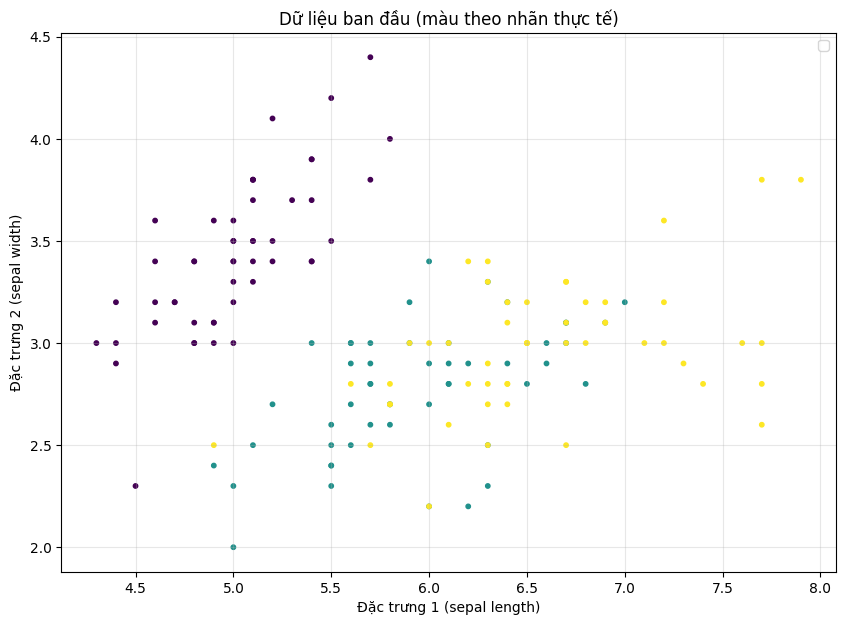

=== BƯỚC 1: KHỞI TẠO TÂM CỤM NGẪU NHIÊN ===
  Tâm 0: [6.1 2.8]
  Tâm 1: [5.7 3.8]
  Tâm 2: [7.7 2.6]
  Tâm 3: [6.  2.9]
  Tâm 4: [6.8 2.8]

--- Lần lặp 1 ---
  Gán nhãn: [23 48  8 44 27] điểm mỗi cụm
  Số điểm thay đổi nhãn: 127
  Tâm cụm mới:
    Tâm 0: [6.16086957 2.63478261]
    Tâm 1: [5.03958333 3.46875   ]
    Tâm 2: [7.625  3.0875]
    Tâm 3: [5.65681818 2.81818182]
    Tâm 4: [6.77777778 3.06666667]

--- Lần lặp 2 ---
  Gán nhãn: [25 49 10 36 30] điểm mỗi cụm
  Số điểm thay đổi nhãn: 21
  Tâm cụm mới:
    Tâm 0: [6.232 2.688]
    Tâm 1: [5.01632653 3.45102041]
    Tâm 2: [7.54 3.15]
    Tâm 3: [5.55 2.7 ]
    Tâm 4: [6.65666667 3.12      ]

--- Lần lặp 3 ---
  Gán nhãn: [29 49 11 31 30] điểm mỗi cụm
  Số điểm thay đổi nhãn: 6
  Tâm cụm mới:
    Tâm 0: [6.18965517 2.73793103]
    Tâm 1: [5.01632653 3.45102041]
    Tâm 2: [7.50909091 3.13636364]
    Tâm 3: [5.48709677 2.63225806]
    Tâm 4: [6.61666667 3.13333333]

--- Lần lặp 4 ---
  Gán nhãn: [29 49 12 31 29] điểm mỗi cụm
  Số 

/content/visualization.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, y, **kwargs)


Lưu ảnh: results/ket_qua_cuoi_cung_20251214_173339.png


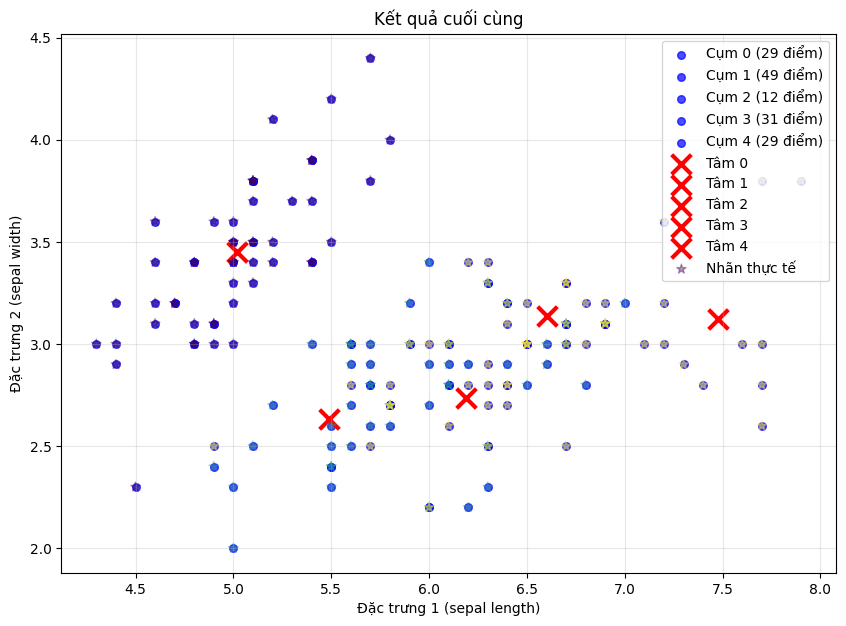


=== BƯỚC 4: SO SÁNH VỚI NHÃN THỰC TẾ ===
Adjusted Rand Index (ARI): 0.4887 (gần 1 là tốt, 0 là ngẫu nhiên)
Confusion Matrix (hàng: nhãn thực, cột: cụm dự đoán):
[[ 0 49  0  1  0]
 [15  0  0 24 11]
 [14  0 12  6 18]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
Gợi ý mapping cụm dự đoán sang nhãn thực (dựa trên đa số):
  Cụm 0 → Nhãn thực 1 (versicolor): 15/29 điểm
  Cụm 1 → Nhãn thực 0 (setosa): 49/49 điểm
  Cụm 2 → Nhãn thực 2 (virginica): 12/12 điểm
  Cụm 3 → Nhãn thực 1 (versicolor): 24/31 điểm
  Cụm 4 → Nhãn thực 2 (virginica): 18/29 điểm
Lưu metrics vào: results/metrics_20251214_173340.txt
Lưu ảnh so sánh: results/comparison_final_20251214_173340.png


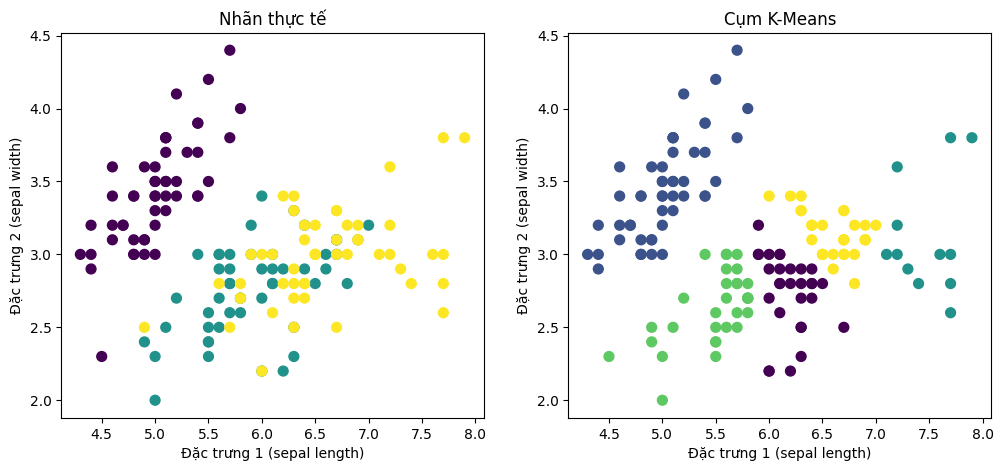

In [24]:

import numpy as np
from data_loader import DataLoader
from kmeans_model import KMeansModel
from visualization import plot_and_save_scatter
from datetime import datetime
import os

if __name__ == "__main__":
    np.random.seed(42)

    # Instantiate DataLoader
    loader = DataLoader()

    # --- Start of fix: Monkey-patching the _plot_and_save_initial_data method ---
    def _fixed_plot_and_save_initial_data(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        title = 'Dữ liệu ban đầu (màu theo nhãn thực tế)' if self.is_iris and self.true_labels is not None else 'Dữ liệu ban đầu'
        marker = 'o'
        s = 10

        c = 'blue'
        cmap = None
        if self.is_iris and self.true_labels is not None:
            c = self.true_labels
            cmap = 'viridis'

        # Prepare the 'scatters' argument for visualization.plot_and_save_scatter
        # This will be the main data points to plot
        initial_scatter_data_args = {
            'c': c,
            'marker': marker,
            's': s,
            'cmap': cmap
        }
        scatters_list = [(self.X[:, 0], self.X[:, 1], initial_scatter_data_args)]

        # Call the plot_and_save_scatter function with correct keyword arguments
        plot_and_save_scatter(
            scatters=scatters_list,
            centers_scatter=None,
            overlay=None,
            title=title,
            xlabel=self.xlabel,
            ylabel=self.ylabel,
            filename_prefix=f'initial_data_{timestamp}'
        )

    # Apply the monkey-patch
    loader._plot_and_save_initial_data = _fixed_plot_and_save_initial_data.__get__(loader, DataLoader)
    # --- End of fix ---

    # Now call the load_data method, which will use the monkey-patched function
    loader.load_data()
    X = loader.X
    true_labels = loader.true_labels
    n_cluster = loader.n_cluster
    xlabel = loader.xlabel
    ylabel = loader.ylabel

    # Chạy K-Means
    model = KMeansModel(n_cluster)
    model.fit(X, verbose=True)

    # Vẽ và lưu kết quả
    model.plot_and_save_results(true_labels, xlabel, ylabel)

    # Đánh giá nếu có nhãn thực tế
    model.evaluate_and_save(true_labels, xlabel, ylabel)
